This is project for MGT351
Group Members: Heeyun Lee and Sarah Chun


## Introduction

We used the dataset of the movies and shows listed on Disney+, a streaming service created by Disney. The dataset has 1,368 unique rows and 12 columns. We got the dataset from [Kaggle](https://www.kaggle.com/shivamb/disney-movies-and-tv-shows)

## Explain the variables (columns) you used (be explicit, e.g, indicate units where relevant)

The dataset includes 1368 unique rows (listing) and 11 variables.

Here are what each variables mean
- `type`: the type of a data, either tv show or movie
- `title`: the title of the listing
- `director`: the director(s) of the listing
- `cast`: the cast(s) of the listing
- `country`: a country or countries of production
- `date_added`: a date added on Disney+
- `release_year`: original release year of the listing
- `rating`: a rating of the listing
- `duration`: total duration of the listing. Minutes for the movies and seasons for tv shows
- `listed_in`: the genre(s) of the listing
- `description`: the description of the listing

Except `release_year`, all varaibles were strings. In our current analysis, we used `duration`, `director`, `listed_in`, `release_year`, and `cast` variables.

To answer questions that were on only movies or only TV shows, we filtered out the original file by type and created separate data frames for each. Before creating one for movies, we added another column called "duration int", which is the duration without "min".

For director, cast, and genres, we first created a list for each separating by commas, got rid of empty strings, and then turned it into a data frame.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import custom_functions

In [2]:
disney = pd.read_csv('disney_plus_titles.csv')

disney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   int64 
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: int64(1), object(11)
memory usage: 136.1+ KB


#### 1. Data Cleaning

In [3]:
# Drop duplicates
disney = disney.drop_duplicates(subset=['show_id'], keep='first')


# Check for NAs
nan_table_start = disney.isna().sum()
print(f'NAs at the beggining: \n{nan_table_start}')

NAs at the beggining: 
show_id           0
type              0
title             0
director        473
cast            190
country         219
date_added        3
release_year      0
rating            3
duration          0
listed_in         0
description       0
dtype: int64


In [4]:
print(disney.isnull().any(axis=1).sum())

632


In [14]:
# Filling Rating NAs manually because there is only 3 NAs
disney[disney['rating'].isna()].loc[:, ['title', 'rating']]

# 	    title	                        rating
# 4	    The Beatles: Get Back	        NaN
# 276	Disney My Music Story: Perfume	NaN
# 280	Marvel Studios ASSEMBLED	    NaN

disney.loc[[4,276,280], 'rating'] = 'TV-14'

In [17]:
# There are 632 rows with at least 1 null value. For each of them, we used OMDB API to fill the missing values.

for index, row in disney[disney.isnull().any(axis=1)].iterrows():

    # Using custom function to get the JSON data of the movie with NA values
    data = custom_functions.get_omdb_data(row['title'], row['release_year'])

    # If the data does not exist, we skip the row
    if pd.isna(data):
        continue

    # If the data exists, we fill the NA values with the data
    else:
        if pd.isna(row['director']) and (data['Director'] != 'N/A'):
            disney.loc[index, 'director'] = data['Director']
        
        if pd.isna(row['cast']) and (data['Actors'] != 'N/A'):
            disney.loc[index, 'cast'] = data['Actors']
        
        if pd.isna(row['country']) and (data['Country'] != 'N/A'):
            disney.loc[index, 'country'] = data['Country']

In [18]:
# The result of filling NA values using REST API
nan_table_end = disney.isna().sum()
print(f'NAs at the end: \n{nan_table_end}')

NAs at the end: 
show_id           0
type              0
title             0
director        443
cast             97
country         140
date_added        3
release_year      0
rating            0
duration          0
listed_in         0
description       0
dtype: int64


In [19]:
disney.replace([np.nan, None, 'N/A'], '', inplace=True)

In [20]:
disney['duration_int'] = disney['duration'].str.strip('min')
disney       ## just to see new column without “min”

## Splitting the data by type
disney_movies, disney_tv_shows = [i for i, i in disney.groupby(disney['type'] == 'TV Show')]

In [21]:
disney_movies.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!,23
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",United States,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...,91
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.,23
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!",41
5,s6,Movie,Becoming Cousteau,Liz Garbus,"Jacques Yves Cousteau, Vincent Cassel",United States,"November 24, 2021",2021,PG-13,94 min,"Biographical, Documentary",An inside look at the legendary life of advent...,94


In [22]:
disney_tv_shows.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int
4,s5,TV Show,The Beatles: Get Back,Peter Jackson,"John Lennon, Paul McCartney, George Harrison, ...","United Kingdom, New Zealand, United States","November 25, 2021",2021,TV-14,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...,1 Seaso
6,s7,TV Show,Hawkeye,,"Jeremy Renner, Hailee Steinfeld, Vera Farmiga,...",United States,"November 24, 2021",2021,TV-14,1 Season,"Action-Adventure, Superhero",Clint Barton/Hawkeye must team up with skilled...,1 Seaso
7,s8,TV Show,Port Protection Alaska,,"Gary Muehlberger, Mary Miller, Curly Leach, Sa...",United States,"November 24, 2021",2015,TV-14,2 Seasons,"Docuseries, Reality, Survival",Residents of Port Protection must combat volat...,2 Seasons
8,s9,TV Show,Secrets of the Zoo: Tampa,,"Dr. Ray Ball, Dr. Lauren Smith, Chris Massaro,...",United States,"November 24, 2021",2019,TV-PG,2 Seasons,"Animals & Nature, Docuseries, Family",A day in the life at ZooTampa is anything but ...,2 Seasons
13,s14,TV Show,"Dr. Oakley, Yukon Vet",,"Dr. Michelle Oakley, Zachary Fine",United States,"November 17, 2021",2013,TV-PG,10 Seasons,"Action-Adventure, Animals & Nature, Docuseries","Meet Dr. Michelle Oakley, vet to pretty much e...",10 Seasons


# Questions and answers (Exploratory Data Analysis)

Below, we explore data and try to answer few questions

In [23]:
# This function gets column name and DataFrame as the parameter and returns the counter
def column_to_counter(column_name: str, data_frame: pd.DataFrame) -> pd.Series:
    starting_list = [str]

    # Creating the list of strings from df
    for item in data_frame[column_name]:
        # if (item is not None) or (item != 'NaN'):
            item_split = str(item).split(',')
            item_strip = [x.strip() for x in item_split if x]

            starting_list += item_strip
    
    # Creating DataFrame to groupby, sort_values, and plot
    starting_list_df = pd.DataFrame(starting_list, columns = [column_name])

    # Creating the counter
    counter = starting_list_df.groupby(column_name)[column_name].count().sort_values(ascending = False)

    return counter
    

### Q1. Who is the most casted TV show actor, and how many TV shows are they a part of?

<AxesSubplot:xlabel='cast'>

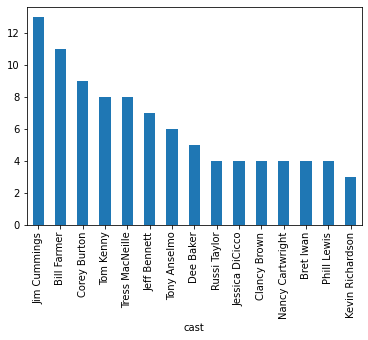

In [26]:
counter = column_to_counter('cast', disney_tv_shows)
counter[:15].plot(kind = 'bar')

#### Answer: Jim Cummings is the most casted TV show actor. He is a part of 13 TV shows on Disney+

### Q2. What percentage of movies have a duration longer than 80 minutes?

In [27]:
disney_movies['duration_int'] = disney_movies['duration_int'].astype(int)
sum(disney_movies['duration_int'] > 88) / len(disney_movies) * 100

44.20152091254753

#### Answer: 44.8% of the movies have a duration of more than 80 minutes

### Q3. Which directors have the most movies on Disney+?

<AxesSubplot:xlabel='director'>

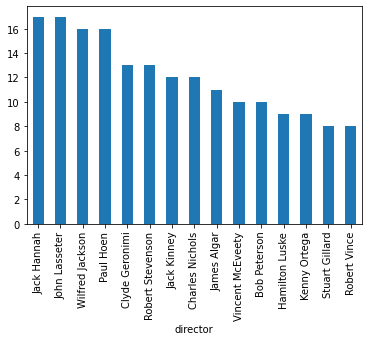

In [28]:
director_counter = column_to_counter('director', disney)
director_counter[:15].plot(kind = 'bar')

#### Answer: Jack Hannah, an American animator, writer, and director, has worked with Disney+ movies/tv shows the most. He worked on 17 movies and tv shows.

### Q4. What are the top 3 movie genres on Disney Plus?

Text(0.5, 0, 'Genre')

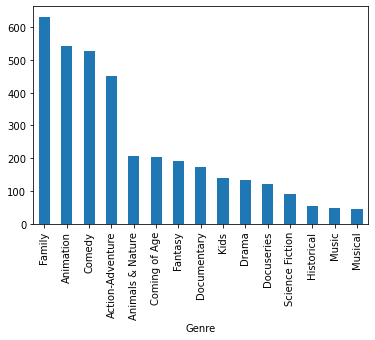

In [29]:
genre_counter = column_to_counter('listed_in', disney)
genre_counter_plot = genre_counter[:15].plot(kind = 'bar')

genre_counter_plot.set_xlabel('Genre')

#### Answer: The top 3 movie genres are Family, Animation, and Comedy

### Q5. Were there more or less family-friendly movies and TV shows over time?


<AxesSubplot:xlabel='release_year'>

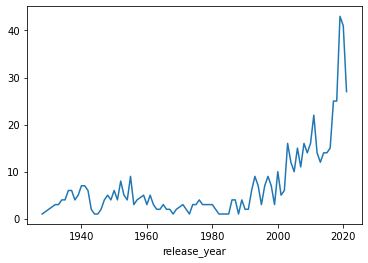

In [30]:
condition2 = disney['listed_in'].str.contains('Family')
disney[condition2].groupby('release_year')['title'].count().plot(kind = 'line')

#### Answer: The number of family-friendly movies and TV shows increased over time

### Q6. Did the duration of movies get longer or shorter over time?

<AxesSubplot:xlabel='release_year'>

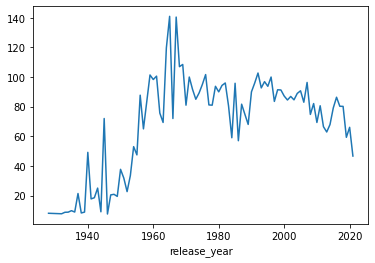

In [31]:
dismovdur = disney_movies.groupby('release_year')['duration_int'].mean()
dismovdur.plot(kind = 'line')

#### Answer: The duration of movies peaked in the 1960's, and has been decreasing since then

#### Q5: I suggest getting the proportion of family-friendly movies and TV shows too. The number of
#### family-friendly offerings might have increased over the years just because the total number of
#### offerings increased

<AxesSubplot:>

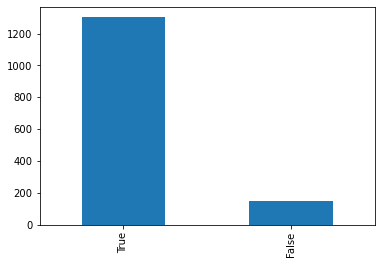

In [38]:
disney['rating'].unique()
# There are 9 unique ratings: ['TV-G', 'PG', 'TV-PG', 'PG-13', 'TV-14', 'G', 'TV-Y7', 'TV-Y', 'TV-Y7-FV']

# '' is null
# 'TV-G', 'PG', 'TV-PG', 'G', 'TV-Y7', 'TV-Y', 'TV-Y7-FV' are family friendly
# 'PG-13', 'TV-14' are NOT family friendly
family_friendly = ['TV-G', 'PG', 'TV-PG', 'G', 'TV-Y7', 'TV-Y', 'TV-Y7-FV']
disney['family_friendly'] = disney['rating'].isin(family_friendly)

disney['family_friendly'].value_counts()

plt.plot()